Импортируем все необходимые библиотеки

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet

Считываем данные

In [11]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv', parse_dates=[0])

In [12]:
df = df.rename(columns={'Дата' : 'ds', 'Число заказов' : 'y'})

In [13]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [14]:
df.shape

(14, 2)

Убираем заказы, вызванные акцией для чистоты прогноза (7%)

In [16]:
difference = (df.loc[5, 'y'] - df.loc[4, 'y']) - ((df.loc[5, 'y'] - df.loc[4, 'y']) * 100 / 107)

In [17]:
difference

21.85046728971963

In [18]:
df.y.loc[5:] = df.y.loc[5:] - round(difference)

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Для того чтобы измерить качество полученного прогноза, уберем из обучения последний месяц данных и будем предсказывать его.

In [19]:
predictions = 5
df.columns = ['ds', 'y']

In [20]:
# отрезаем из обучающей выборки последние 5 точек, чтобы измерить на них качество
train_df = df[:-predictions] 

Далее создаем объект класса Prophet, задаем недельную сезонность

In [21]:
m = Prophet(weekly_seasonality=True)
m.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


С помощью вспомогательной функции Prophet.make_future_dataframe создаем dataframe, который содержит все исторические временные точки и еще 5 недель, для которых мы хотели построить прогноз.

In [22]:
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)

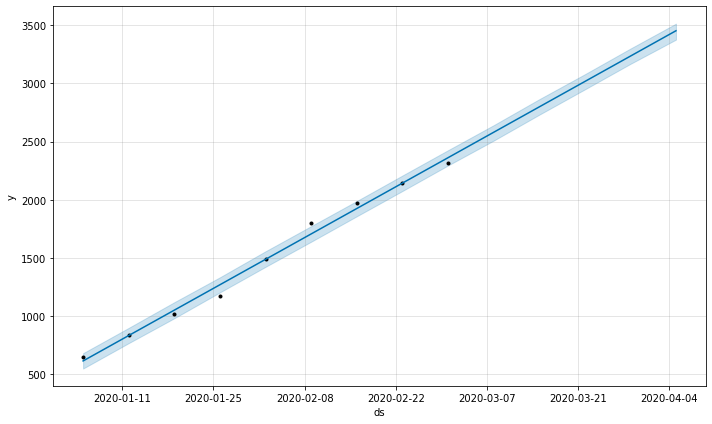

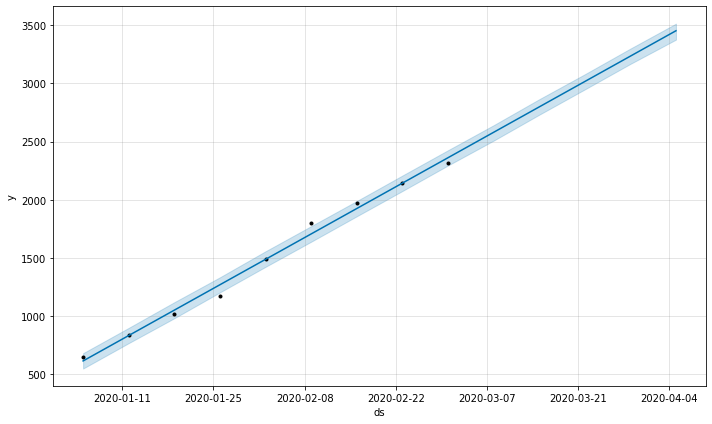

In [23]:
m.plot(forecast)

In [24]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [25]:
#рассчитываем основные ошибки модели, чтоб оценить ее качество
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  7.269135093211008 %
MAE (средняя абсолютная ошибка) –  256.6640676205151


Строим график полученной модели

In [26]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

Теперь строим модель на полных данных и на нужный нам период (14 недель)

In [57]:
predictions = 14

In [28]:
p = Prophet(weekly_seasonality=True)
p.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


In [29]:
future = p.make_future_dataframe(periods=predictions, freq='W')
three_months_forecast = p.predict(future)

Строим график нашего прогноза

In [31]:
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=three_months_forecast['ds'], y=three_months_forecast['yhat'], name='yhat'),
    go.Scatter(x=three_months_forecast['ds'], y=three_months_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=three_months_forecast['ds'], y=three_months_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=three_months_forecast['ds'], y=three_months_forecast['trend'], name='trend')
])

Получим датафрейм с спрогнозированными значениями

In [36]:
three_months_forecast_orders = three_months_forecast[['ds', 'yhat']].rename(columns={'ds' : 'Дата', 'yhat' : 'Спрогнозированное число заказов'})
three_months_forecast_orders

,Дата,Спрогнозированное число заказов
0,2020-01-05,616.289238
1,2020-01-12,834.285946
2,2020-01-19,1052.282650
3,2020-01-26,1270.347810
4,2020-02-02,1488.412972
5,2020-02-09,1706.478140
6,2020-02-16,1924.540408
7,2020-02-23,2142.602669
8,2020-03-01,2360.664930
9,2020-03-08,2578.727191
